In [1]:
!pip install networkx



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


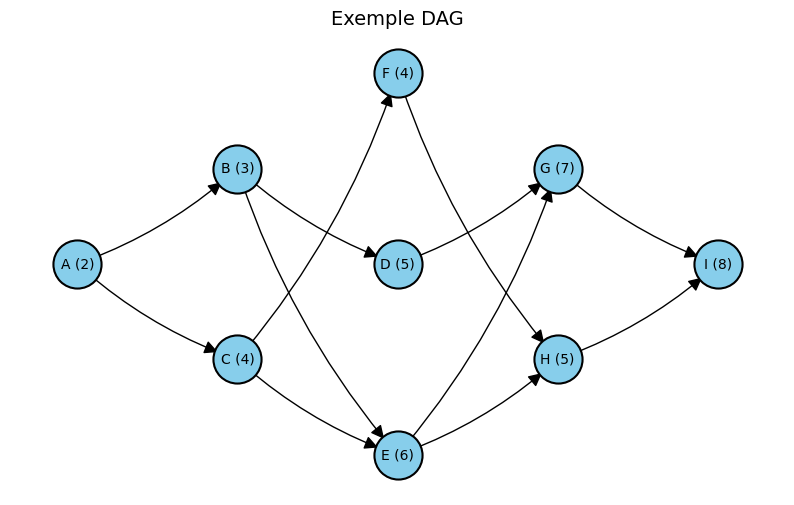

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Création du DAG
dag = nx.DiGraph()

# Ajout des nœuds avec leurs poids
tasks = {
    "A": 2, "B": 3, "C": 4, "D": 5, "E": 6, 
    "F": 4, "G": 7, "H": 5, "I": 8
}
dag.add_nodes_from(tasks.keys())

# Ajout des dépendances (arêtes)
dependencies = [
    ("A", "B"), ("A", "C"),
    ("B", "D"), ("B", "E"),
    ("C", "E"), ("C", "F"),
    ("D", "G"), ("E", "G"), ("E", "H"), ("F", "H"),
    ("G", "I"), ("H", "I")
]
dag.add_edges_from(dependencies)

# Définition des niveaux des nœuds
node_levels = {
    "A": 0, "B": 1, "C": 1, 
    "D": 2, "E": 2, "F": 2, 
    "G": 3, "H": 3, "I": 4
}

# Ajout des niveaux comme attributs des nœuds
nx.set_node_attributes(dag, node_levels, "subset")

# Positionnement des nœuds
pos = nx.multipartite_layout(dag, subset_key="subset")

# Dessin du graphe
plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(dag, pos, node_size=1200, node_color="skyblue", edgecolors="black", linewidths=1.5)
nx.draw_networkx_labels(dag, pos, labels={n: f"{n} ({tasks[n]})" for n in dag.nodes}, font_size=10)

# Dessin des arêtes avec des flèches BIEN VISIBLES DEVANT LES NŒUDS
nx.draw_networkx_edges(
    dag, pos, arrowstyle="-|>", arrows=True, arrowsize=20, edge_color="black",
    connectionstyle="arc3,rad=0.1", min_target_margin=15  # Évite que les flèches soient cachées
)

plt.title("Exemple DAG", fontsize=14)
plt.axis("off")
plt.show()


Algo HLFET

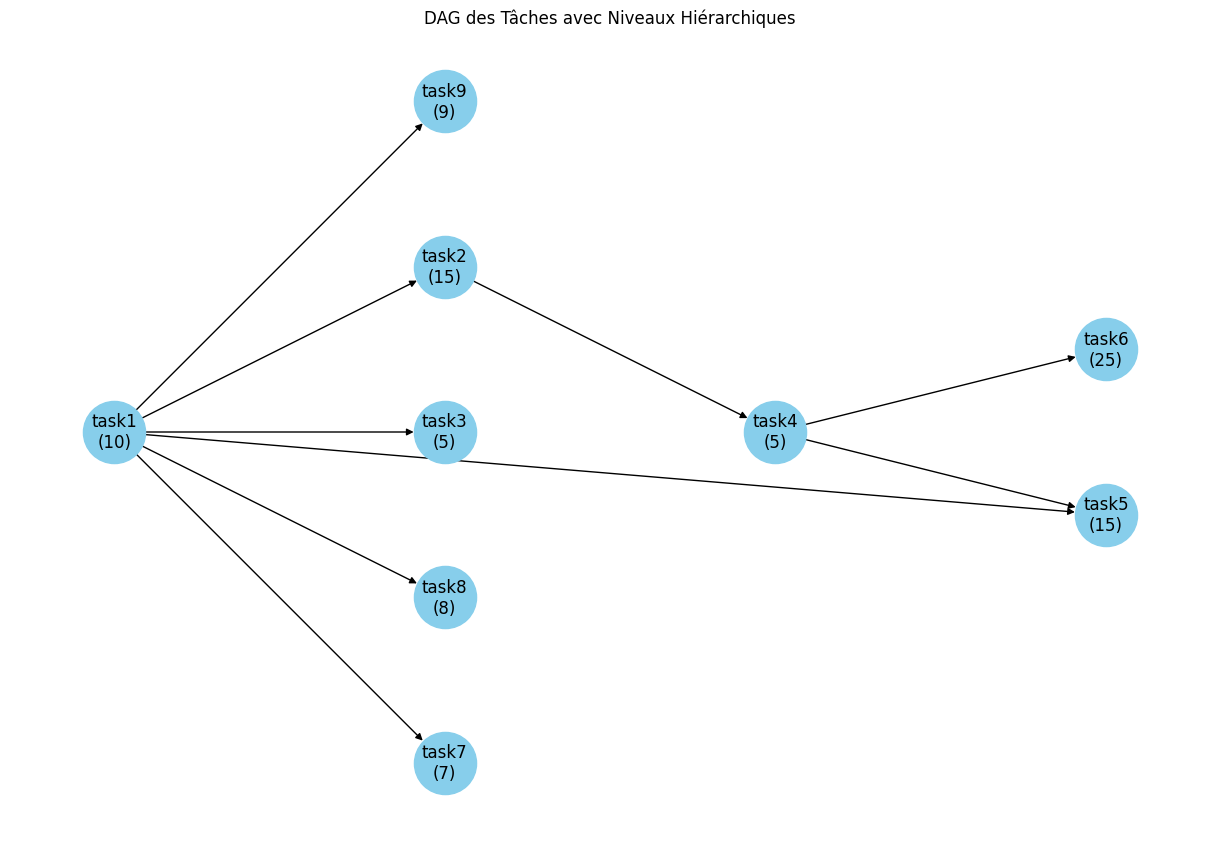

/var/folders/qw/ldhtc8456654kqm2fllkbf9c0000gn/T/ipykernel_53540/2104957746.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', 10)


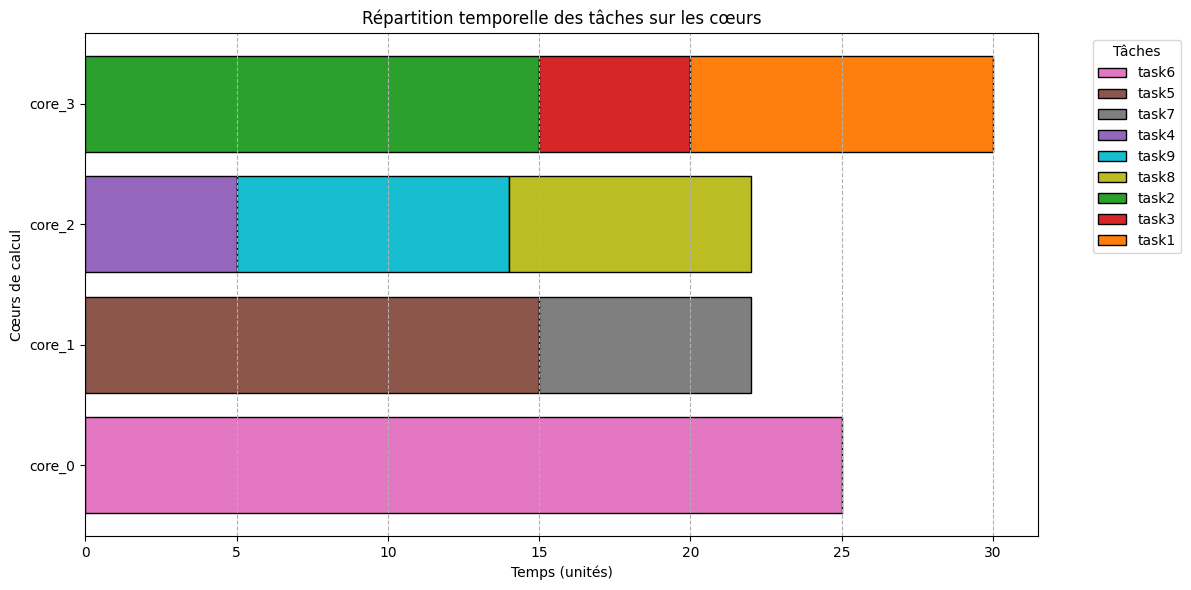

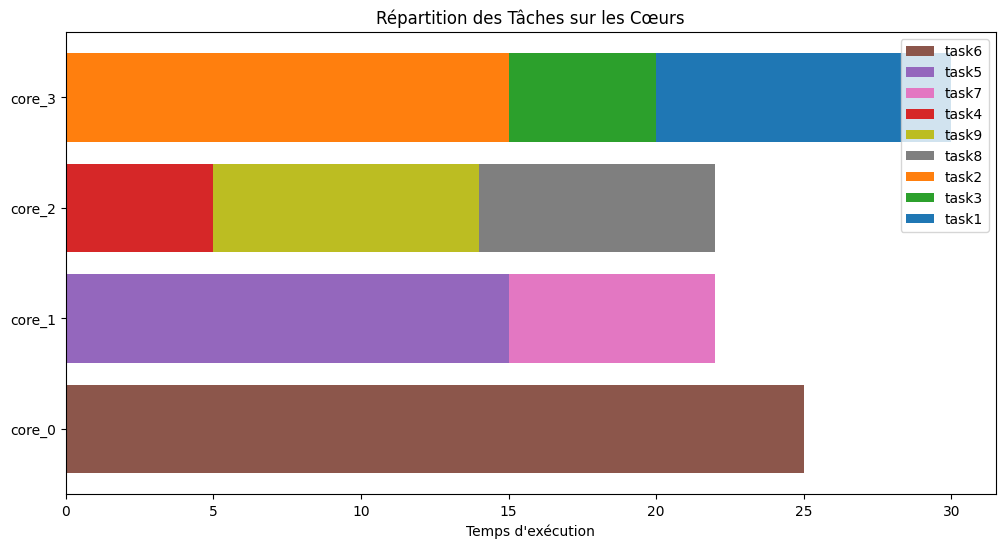

In [ ]:
import json
## import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

def hlfet_scheduler(input_data, num_cores):
    # Parse input data
    tasks = {task["id"]: {
        "duration": task["duration"] ,
        "dependencies": task["dependencies"]
    } for task in input_data["tasks"]}

    # Create DAG
    dag = nx.DiGraph()
    
    # Add nodes and edges
    for task_id, task_data in tasks.items():
        dag.add_node(task_id, duration=task_data["duration"])
        for dep in task_data["dependencies"]:
            dag.add_edge(dep, task_id)

    # Calculate task levels and store as node attribute
    levels = {}
    for node in nx.topological_sort(dag):
        if not list(dag.predecessors(node)):
            levels[node] = 0
        else:
            levels[node] = max(levels[pred] for pred in dag.predecessors(node)) + 1
        dag.nodes[node]['level'] = levels[node]  # Stocke le niveau comme attribut

    # Sort tasks by level and duration
    sorted_tasks = sorted(tasks.keys(), 
                         key=lambda x: (-levels[x], -tasks[x]["duration"]), 
                         reverse=False)

    # Initialize scheduling
    schedule = {f"core_{i}": [] for i in range(num_cores)}
    core_availability = {i: 0 for i in range(num_cores)}

    # Schedule tasks
    for task in sorted_tasks:
        # Calculate earliest start time based on dependencies
        est = max([core_availability[i] for i in range(num_cores) 
                 if any(pred in [t[0] for t in schedule[f"core_{i}"]] 
                    for pred in tasks[task]["dependencies"])], default=0)
        
        # Find best core
        best_core = min(core_availability, 
                       key=lambda c: max(core_availability[c], est) + tasks[task]["duration"])
        
        start_time = max(core_availability[best_core], est)
        end_time = start_time + tasks[task]["duration"]
        
        # Update schedule
        schedule[f"core_{best_core}"].append((task, start_time, end_time))
        core_availability[best_core] = end_time

    return schedule, dag

def plot_core_distribution(schedule):
    plt.figure(figsize=(12, 6))
    colors = cm.get_cmap('tab10', 10)
    
    # Création des barres horizontales pour chaque coeur
    for i, (core, tasks) in enumerate(schedule.items()):
        for task in tasks:
            duration = task[2] - task[1]
            plt.barh(y=i, 
                    width=duration,
                    left=task[1],
                    color=colors(int(task[0][4:]) % 10), # Couleur basée sur le numéro de tâche
                    edgecolor='black',
                    label=task[0])

    # Configuration de l'axe Y
    plt.yticks(range(len(schedule)), schedule.keys())
    plt.ylabel("Cœurs de calcul")
    
    # Configuration de l'axe X
    plt.xlabel("Temps (unités)")
    plt.title("Répartition temporelle des tâches sur les cœurs")
    
    # Gestion de la légende
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    plt.legend(unique_labels.values(), unique_labels.keys(), 
            title='Tâches', bbox_to_anchor=(1.05, 1), 
            loc='upper left')

    plt.grid(axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()



def plot_schedule(dag, schedule):
    # Plot DAG avec niveaux
    pos = nx.multipartite_layout(dag, subset_key='level')
    plt.figure(figsize=(12, 8))
    
    # Correction ici : ajout de la boucle pour générer les labels
    labels = {node: f"{node}\n({dag.nodes[node]['duration']})" for node in dag.nodes()}
    
    nx.draw(dag, pos, with_labels=True, node_size=2000, node_color='skyblue', 
            labels=labels)
    plt.title("DAG des Tâches avec Niveaux Hiérarchiques")
    plt.show()

    plot_core_distribution(schedule)


    # Plot répartition sur les coeurs
    plt.figure(figsize=(12, 6))
    colors = plt.cm.tab10.colors
    for i, (core, tasks) in enumerate(schedule.items()):
        for task in tasks:
            plt.barh(i, task[2]-task[1], left=task[1], 
                    label=task[0], color=colors[int(task[0][4:])-1])
    
    plt.yticks(range(len(schedule)), schedule.keys())
    plt.xlabel("Temps d'exécution")
    plt.title("Répartition des Tâches sur les Cœurs")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')
    plt.show()


# Exemple d'utilisation
input_json = {
    "graph_id": "graph_example",
    "tasks": [
        {"id": "task1", "duration": 10, "memory": 512, "dependencies": []},
        {"id": "task2", "duration": 15, "memory": 1024, "dependencies": ["task1"]},
        {"id": "task3", "duration": 5, "memory": 256, "dependencies": ["task1"]},
        {"id": "task4", "duration": 5, "memory": 256, "dependencies": ["task2"]},
        {"id": "task5", "duration": 15, "memory": 256, "dependencies": ["task1", "task4"]},
        {"id": "task6", "duration": 25, "memory": 256, "dependencies": ["task4"]},
        {"id": "task7", "duration": 7, "memory": 256, "dependencies": ["task1"]},
        {"id": "task8", "duration": 8, "memory": 256, "dependencies": ["task1"]},
        {"id": "task9", "duration": 9, "memory": 256, "dependencies": ["task1"]}
    ]
}

num_cores = 4
schedule, dag = hlfet_scheduler(input_json, num_cores)
plot_schedule(dag, schedule)


hfyghghg

In [11]:
import json

def hlfet_scheduler(input_data, num_cores):
    # Parse input data
    tasks = {task["id"]: {
        "duration": task["duration"],
        "dependencies": task["dependencies"]
    } for task in input_data["tasks"]}

    # Create DAG
    dag = nx.DiGraph()
    
    # Add nodes and edges
    for task_id, task_data in tasks.items():
        dag.add_node(task_id, duration=task_data["duration"])
        for dep in task_data["dependencies"]:
            dag.add_edge(dep, task_id)

    # Calculate task levels
    levels = {}
    for node in nx.topological_sort(dag):
        if not list(dag.predecessors(node)):
            levels[node] = 0
        else:
            levels[node] = max(levels[pred] for pred in dag.predecessors(node)) + 1

    # Sort tasks by level and duration
    sorted_tasks = sorted(tasks.keys(), 
                        key=lambda x: (-levels[x], -tasks[x]["duration"]), 
                        reverse=False)

    # Initialize scheduling
    schedule = {f"core_{i}": [] for i in range(num_cores)}
    core_availability = {i: 0 for i in range(num_cores)}

    # Schedule tasks
    for task in sorted_tasks:
        # Calculate earliest start time based on dependencies
        est = 0
        for pred in tasks[task]["dependencies"]:
            pred_finish = max([core_availability[i] - schedule[f"core_{i}"][-1][1] 
                            for i in range(num_cores) if any(t[0] == pred for t in schedule[f"core_{i}"])], default=0)
            est = max(est, pred_finish)

        # Find best core
        best_core = min(core_availability, 
                    key=lambda c: max(core_availability[c], est) + tasks[task]["duration"])
        
        start_time = max(core_availability[best_core], est)
        end_time = start_time + tasks[task]["duration"]
        
        # Update schedule and core availability
        schedule[f"core_{best_core}"].append((task, start_time))
        core_availability[best_core] = end_time

    # Format output
    formatted_schedule = {}
    for core, tasks in schedule.items():
        formatted_schedule[core] = sorted([
            {"task": t[0], "start_time": t[1]} 
            for t in tasks
        ], key=lambda x: x["start_time"])

    return formatted_schedule

# Exemple d'utilisation
input_json = {
    "graph_id": "graph_example",
    "tasks": [
        {"id": "task1", "duration": 10, "memory": 512, "dependencies": []},
        {"id": "task2", "duration": 15, "memory": 1024, "dependencies": ["task1"]},
        {"id": "task3", "duration": 5, "memory": 256, "dependencies": ["task1"]},
        {"id": "task4", "duration": 5, "memory": 256, "dependencies": ["task2"]},
        {"id": "task5", "duration": 15, "memory": 256, "dependencies": ["task1", "task4"]},
        {"id": "task6", "duration": 25, "memory": 256, "dependencies": ["task4"]},
        {"id": "task7", "duration": 7, "memory": 256, "dependencies": ["task1"]},
        {"id": "task8", "duration": 8, "memory": 256, "dependencies": ["task1"]},
        {"id": "task9", "duration": 9, "memory": 256, "dependencies": ["task1"]}
    ]
}

output = hlfet_scheduler(input_json, num_cores=4)
print(json.dumps(output, indent=2))

NameError: name 'nx' is not defined

In [3]:
!pip install scheduler
!pip install scipy.interpolate

ERROR: Could not find a version that satisfies the requirement scipy.interpolate (from versions: none)
ERROR: No matching distribution found for scipy.interpolate


In [5]:
import os
print(os.listdir())

['dispense_sport.pdf', 'Compte à terme mr VALLET ALEXANDRE .pdf', 'opm.png', 'dispence_sport.jpeg', 'test_plot.py', 'information personnelle', 'Scuba_presentation.pptx', 'Compte à terme mr VALLET ALEXANDRE à signer 2 copy.pdf', 'CV .docx', 'IMG_0135.heic', '.DS_Store', 'échange', 'facture_SFR_2024', 'soirée cohesion 24:10.pdf', 'Parcours Entrepreneriat', '341212_VALLET_FR.docx', 'EPFL', '.localized', 'Certificat de scolarité.pdf', 'video_Sigvard.mp4', '~$ttre_master.docx', 'lycée', 'crypto.docx', '~$nal task 2 modif - copie.docx', 'CS', 'Marathon_intermediate_2025.pdf', 'VALLET Alexandre LA .pdf', 'banière.jpeg', 'der.png', 'Vallet_Alexandre_2300374.csv', 'Hotel - imp.pdf', 'Screenshot 2023-05-17 at 13.05.55.png', 'dossier centrale', 'lettre motiv', 'Screenshot 2024-07-11 at 15.40.18.png', 'Sweden_map.jpg', 'Screenshot 2025-03-17 at 11.24.15.png', '~$P_macopro.docx', 'klm.JPG', 'Natsuc', 'sommaire procedé de prod.pdf', 'césal', 'logo.png', 'TP_V2X.docx', 'Screenshot 2022-11-2

In [6]:
print(os.getcwd())

/Users/alexander/Desktop


/opt/homebrew/lib/python3.11/site-packages/scheduler/__init__.py


In [14]:


import json
import random
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
import numpy as np



[
    {
        "num_tasks": 41,
        "execution_time": 0.0004680156707763672,
        "dependency_coefficient": 2.8536585365853657
    },
    {
        "num_tasks": 28,
        "execution_time": 0.00024890899658203125,
        "dependency_coefficient": 2.7857142857142856
    },
    {
        "num_tasks": 87,
        "execution_time": 0.000982046127319336,
        "dependency_coefficient": 2.9310344827586206
    },
    {
        "num_tasks": 89,
        "execution_time": 0.0013670921325683594,
        "dependency_coefficient": 2.932584269662921
    },
    {
        "num_tasks": 79,
        "execution_time": 0.0008749961853027344,
        "dependency_coefficient": 2.9240506329113924
    },
    {
        "num_tasks": 75,
        "execution_time": 0.0008339881896972656,
        "dependency_coefficient": 2.92
    },
    {
        "num_tasks": 70,
        "execution_time": 0.0007660388946533203,
        "dependency_coefficient": 2.914285714285714
    },
    {
        "num_tasks": 75,
   

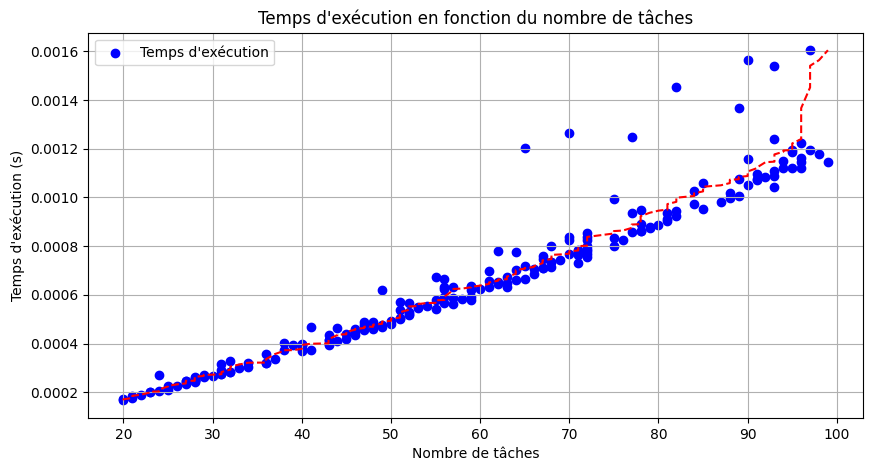

/var/folders/qw/ldhtc8456654kqm2fllkbf9c0000gn/T/ipykernel_35856/2394105379.py:160: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(dag.nodes))


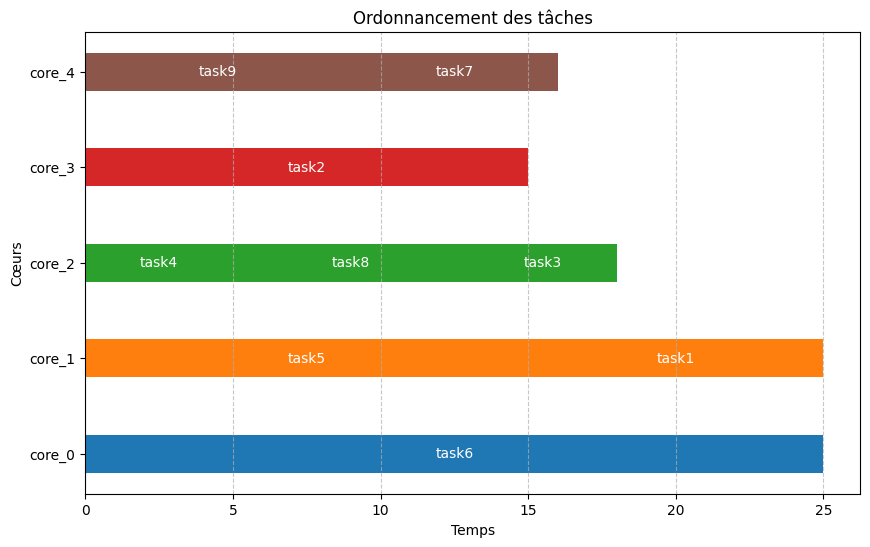

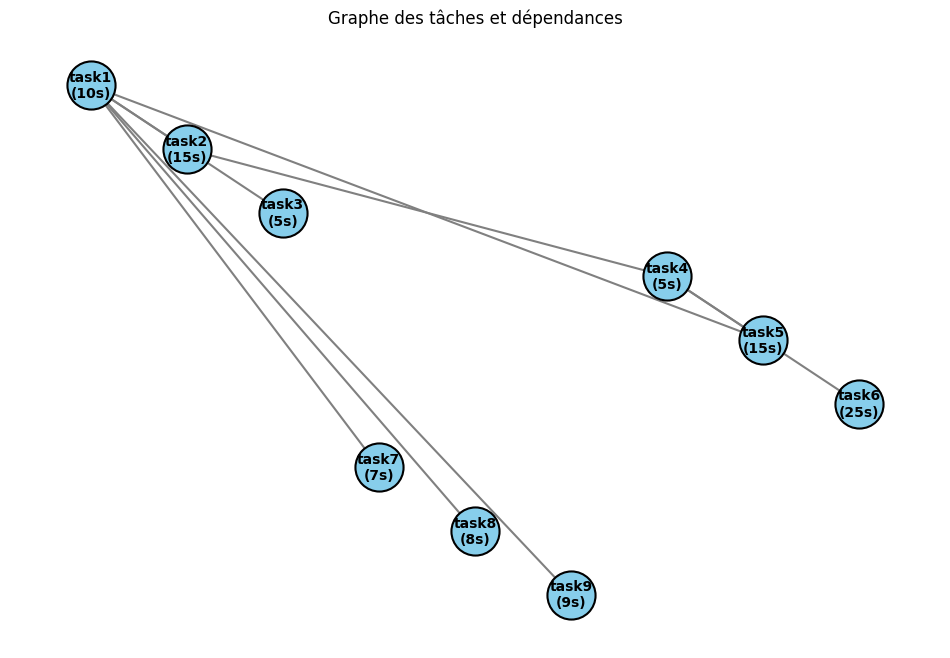

In [44]:
def hlfet_scheduler(input_data, num_cores):
    # Parse input data
    tasks = {task["id"]: {
        "duration": task["duration"],
        "dependencies": task["dependencies"]
    } for task in input_data["tasks"]}

    # Create DAG
    dag = nx.DiGraph()
    
    # Add nodes and edges
    for task_id, task_data in tasks.items():
        dag.add_node(task_id, duration=task_data["duration"])
        for dep in task_data["dependencies"]:
            dag.add_edge(dep, task_id)

    # Calculate task levels
    levels = {}
    for node in nx.topological_sort(dag):
        if not list(dag.predecessors(node)):
            levels[node] = 0
        else:
            levels[node] = max(levels[pred] for pred in dag.predecessors(node)) + 1

    # Sort tasks by level and duration
    sorted_tasks = sorted(tasks.keys(), 
                        key=lambda x: (-levels[x], -tasks[x]["duration"]), 
                        reverse=False)

    # Initialize scheduling
    schedule = {f"core_{i}": [] for i in range(num_cores)}
    core_availability = {i: 0 for i in range(num_cores)}

    # Schedule tasks
    for task in sorted_tasks:
        # Calculate earliest start time based on dependencies
        est = 0
        for pred in tasks[task]["dependencies"]:
            pred_finish = max([core_availability[i] - schedule[f"core_{i}"][-1][1] 
                            for i in range(num_cores) if any(t[0] == pred for t in schedule[f"core_{i}"])], default=0)
            est = max(est, pred_finish)

        # Find best core
        best_core = min(core_availability, 
                    key=lambda c: max(core_availability[c], est) + tasks[task]["duration"])
        
        start_time = max(core_availability[best_core], est)
        end_time = start_time + tasks[task]["duration"]
        
        # Update schedule and core availability
        schedule[f"core_{best_core}"].append((task, start_time))
        core_availability[best_core] = end_time

    # Format output
    formatted_schedule = {}
    for core, tasks in schedule.items():
        formatted_schedule[core] = sorted([
            {"task": t[0], "start_time": t[1]} 
            for t in tasks
        ], key=lambda x: x["start_time"])

    return formatted_schedule, dag  # Ajout du retour du DAG


def generate_random_graph(num_tasks, max_duration=20, max_dependencies=3):
    tasks = []
    for i in range(1, num_tasks + 1):
        task_id = f"task{i}"
        duration = random.randint(1, max_duration)
        dependencies = random.sample(
            [f"task{j}" for j in range(1, i)], k=min(len(range(1, i)), max_dependencies)
        ) if i > 1 else []
        tasks.append({"id": task_id, "duration": duration, "dependencies": dependencies})
    
    return {"graph_id": f"graph_{num_tasks}", "tasks": tasks}

def compute_dependency_coefficient(graph):
    num_nodes = len(graph["tasks"])
    num_edges = sum(len(task["dependencies"]) for task in graph["tasks"])
    return num_edges / num_nodes if num_nodes > 0 else 0

def run_experiments(iterations, min_tasks, max_tasks, num_cores):
    results = []
    
    for _ in range(iterations):
        num_tasks = random.randint(min_tasks, max_tasks)
        input_json = generate_random_graph(num_tasks)
        dependency_coefficient = compute_dependency_coefficient(input_json)
        
        start_time = time()
        schedule, dag = hlfet_scheduler(input_json, num_cores)
        exec_time = time() - start_time
        
        results.append({
            "num_tasks": num_tasks, 
            "execution_time": exec_time,
            "dependency_coefficient": dependency_coefficient
        })
    
    return results

def plot_execution_times(results):
    num_tasks = [res["num_tasks"] for res in results]
    exec_times = [res["execution_time"] for res in results]
    
    plt.figure(figsize=(10, 5))
    plt.scatter(num_tasks, exec_times, color='b', label='Temps d\'exécution')
    plt.plot(sorted(num_tasks), sorted(exec_times), linestyle='--', color='r')
    plt.xlabel("Nombre de tâches")
    plt.ylabel("Temps d'exécution (s)")
    plt.title("Temps d'exécution en fonction du nombre de tâches")
    plt.legend()
    plt.grid()
    plt.show()

def plot_3d_execution_surface(results):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    num_tasks = np.array([res["num_tasks"] for res in results])
    exec_times = np.array([res["execution_time"] for res in results])
    dependency_coeffs = np.array([res["dependency_coefficient"] for res in results])
    
    # Création d'une grille pour interpoler les données
    grid_x, grid_y = np.meshgrid(
        np.linspace(num_tasks.min(), num_tasks.max(), 30),
        np.linspace(dependency_coeffs.min(), dependency_coeffs.max(), 30)
    )
    grid_z = griddata((num_tasks, dependency_coeffs), exec_times, (grid_x, grid_y), method='cubic')
    
    ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', alpha=0.7)
    ax.scatter(num_tasks, dependency_coeffs, exec_times, c=exec_times, cmap='viridis', marker='o')
    ax.set_xlabel("Nombre de tâches")
    ax.set_ylabel("Coefficient de dépendance")
    ax.set_zlabel("Temps d'exécution (s)")
    ax.set_title("Surface 3D du temps d'exécution en fonction de la dépendance et du nombre de tâches")
    
    plt.show()




def compute_task_levels(dag):
    # Calculer les niveaux des tâches
    levels = {}
    for task in nx.topological_sort(dag):
        task_levels = [levels.get(pred, 0) for pred in dag.predecessors(task)]
        levels[task] = max(task_levels, default=0) + 1
    return levels

def plot_schedule(dag, schedule):
    task_levels = compute_task_levels(dag)

    # Initialiser un dictionnaire pour suivre le temps des cœurs
    core_times = {core: 0 for core in schedule.keys()}

    fig, ax = plt.subplots(figsize=(10, 6))

    # Définir les couleurs pour les cœurs
    colors = plt.cm.get_cmap("tab10", len(dag.nodes))

    # Créer une liste pour trier les tâches par niveau et ordre d'exécution
    all_tasks = []

    # Les tâches sont planifiées par cœur et par niveau
    for core, tasks in schedule.items():
        core_id = int(core.split("_")[1])  # Extraire l'index du cœur
        for task in tasks:
            task_id = task["task"]
            duration = dag.nodes[task_id]["duration"]
            
            # Trouver le temps de début de la tâche : dépend des dépendances et du dernier temps sur le cœur
            start_time = max(core_times[core], max([core_times[core] for core in schedule if core != core] + [0]))  # Assurer qu'il commence après les tâches précédentes

            # Mettre à jour le temps du cœur pour la tâche suivante
            end_time = start_time + duration
            core_times[core] = end_time

            all_tasks.append((task_id, core_id, start_time, end_time, duration))

    # Trier les tâches d'abord par niveau, puis par start_time (ordre d'exécution)
    all_tasks.sort(key=lambda x: (task_levels[x[0]], x[2]))  # Tri par niveau et start_time

    # Tracer les tâches avec leur durée
    for task_id, core_id, start_time, end_time, duration in all_tasks:
        ax.barh(y=core_id, width=duration, left=start_time, 
                height=0.4, label=task_id, color=colors(core_id % 10))  # % 10 pour gérer plusieurs cœurs

        # Ajouter le nom de la tâche à l'intérieur de la barre
        ax.text(start_time + duration / 2, core_id, task_id,
                ha="center", va="center", fontsize=10, color="white")

    # Ajouter les labels des axes et le titre
    ax.set_xlabel("Temps")
    ax.set_ylabel("Cœurs")
    ax.set_title("Ordonnancement des tâches")

    # Ajuster les ticks des axes
    ax.set_yticks(range(len(schedule)))
    ax.set_yticklabels(schedule.keys())

    # Afficher la grille pour l'axe X (temps)
    ax.grid(axis="x", linestyle="--", alpha=0.7)

    # Afficher le graphique
    plt.show()








def plot_task_graph(dag):
    plt.figure(figsize=(12, 8))

    # Calcul des niveaux des tâches en fonction de l'ordre topologique
    levels = {}
    for i, node in enumerate(nx.topological_sort(dag)):
        levels[node] = i  # Assigner à chaque tâche son niveau (ordre topologique)

    # Définir la position des nœuds en fonction de leurs niveaux
    pos = {node: (levels[node], -i) for i, node in enumerate(dag.nodes)}

    # Dessiner les nœuds
    nx.draw_networkx_nodes(dag, pos, node_size=1200, node_color="skyblue", edgecolors="black", linewidths=1.5)
    
    # Dessiner les arêtes (dépendances) avec des flèches
    nx.draw_networkx_edges(dag, pos, edge_color="gray", width=1.5, arrows=True, arrowstyle='-|>', arrowsize=15)
    
    # Ajouter les labels avec la durée des tâches
    labels = {n: f"{n}\n({dag.nodes[n]['duration']}s)" for n in dag.nodes}
    nx.draw_networkx_labels(dag, pos, labels=labels, font_size=10, font_weight="bold")

    # Titre du graphique
    plt.title("Graphe des tâches et dépendances")
    plt.axis('off')  # Masquer les axes
    plt.show()
# Configuration des expériences
iterations = 200
min_tasks = 20
max_tasks = 100
num_cores = 5

# Lancer les expériences et afficher les résultats
experiment_results = run_experiments(iterations, min_tasks, max_tasks, num_cores)
print(json.dumps(experiment_results, indent=4))

# Tracer les graphiques
plot_execution_times(experiment_results)
# plot_3d_execution_surface(experiment_results)

schedule, dag = hlfet_scheduler(input_json, num_cores)
plot_schedule(dag, schedule)
plot_task_graph(dag)

Algo génération de DAG

In [ ]:
import json
import random
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
import numpy as np
from scipy.interpolate import griddata


In [ ]:
def generate_random_graph(num_tasks, max_duration=20, max_dependencies=3):
    tasks = []
    for i in range(1, num_tasks + 1):
        task_id = f"task{i}"
        duration = random.randint(1, max_duration)
        dependencies = random.sample(
            [f"task{j}" for j in range(1, i)], k=min(len(range(1, i)), max_dependencies)
        ) if i > 1 else []
        tasks.append({"id": task_id, "duration": duration, "dependencies": dependencies})
    
    return {"graph_id": f"graph_{num_tasks}", "tasks": tasks}



Algo Glouton : 

Algo Exacte :